AD: Melisa Azra

SOYAD: Tekin

Okul Numarası: 2212721043

GitHub Repo Bağlantısı: https://github.com/melssazra/genetik_optimizasyonu


x1:Ortalama hız (km/h) -> [40,100]
x2: yük kapasitesi (ton) -> [2,10]
Amaç fonk.: y=-2*x1-3*x2 +0,1*x1*x2
kısıtlar:,1. x1*x2 <= 700
2. x1>= 60

In [35]:
import numpy as np
import random

#Amaç fonksiyonu
def amac_fonksiyonu(birey):
  x1,x2 = birey
  return -2*x1 -3*x2 + 0.1*x1*x2

#kısıtlar
def kisit_kontrol(birey):
  x1,x2 = birey
  ceza =0
  if x1*x2 > 700:
    ceza +=1
  if x1 < 60:
    ceza +=1
  return ceza

In [36]:
#uygunluk
def uygunluk_hesapla(birey):
  y=amac_fonksiyonu(birey)
  ceza=kisit_kontrol(birey)*100
  fitness= y-ceza
  return fitness

In [37]:
#rulet seçimi
def rulet(populasyon,uygunluklar, adet=2):
  populasyon=np.array(populasyon)
  uygunluklar=np.array(uygunluklar,dtype=float)
  toplam= np.sum(uygunluklar)
  if toplam <=0:
    olasiliklar=np.ones_like(uygunluklar)/len(uygunluklar)
  else:
    olasiliklar= uygunluklar/toplam
  indeksler=np.random.choice(len(populasyon),size=adet,p=olasiliklar)
  return populasyon[indeksler]

#rank
def rank(populasyon,uygunluklar,adet=2):
  populasyon = np.array(populasyon)
  uygunluklar = np.array(uygunluklar,dtype=float)
  N=len(populasyon)
  sirali= np.argsort(- uygunluklar)
  payda= N*(N+1)/2
  secim_iht= np.array([(N-i)/payda for i in range(N)])
  ihtimaller =np.zeros_like(secim_iht, dtype=float)
  for i,idx in enumerate(sirali):
    ihtimaller[idx]=secim_iht[i]
  indeksler=np.random.choice(N,size=adet,p=ihtimaller)
  return populasyon[indeksler]

In [38]:
#Çaprazlama
def tek_caprazlama(p1,p2):
  nokta = random.randint(1,len(p1)-1)
  c1= np.concatenate((p1[:nokta],p2[nokta:]))
  c2= np.concatenate((p2[:nokta],p1[nokta:]))
  return c1,c2

def iki_caprazlama(p1,p2):
  nokta = random.randint(1,len(p1)-1)
  c1= np.concatenate((p1[:nokta],p2[nokta:]))
  c2= np.concatenate((p2[:nokta],p1[nokta:]))
  return c1,c2

In [39]:
#mutasyon
def mutasyon(birey,ihtimal,buyukluk):
  yeni = birey.copy()
  for i in range(len(yeni)):
    if np.random.rand()<ihtimal:
      delta = (np.random.rand()*2-1) *buyukluk
      yeni[i] = yeni[i] + delta

  yeni[0] = np.clip(yeni[0],40,100)
  yeni[1] = np.clip(yeni[1],2,10)
  return yeni

In [40]:
def baslangic_pop(pop_boyut):
  x1= np.random.uniform(40,100,size=(pop_boyut,1))
  x2= np.random.uniform(2,10,size=(pop_boyut,1))
  return np.hstack([x1,x2])

In [41]:
def evrimsel_algoritma(populasyon, nesil_sayisi,
                       caprazlama_turu="tek",
                       secim_turu="rulet",
                       mutasyon_ihtimali=0.1,
                       mutasyon_buyuklugu=0.2):

    en_iyiler = []

    for nesil in range(nesil_sayisi):
        print(f"Nesil: {nesil+1}")

        # Uygunluk hesapla
        uygunluklar = np.array([uygunluk_hesapla(b) for b in populasyon])

        # En iyi birey (elitizm)
        en_iyi_indeks = np.argmax(uygunluklar)
        elit_birey = populasyon[en_iyi_indeks].copy()
        elit_uygunluk = uygunluklar[en_iyi_indeks]
        en_iyiler.append(elit_uygunluk)

        print("Uygunluklar:", np.round(uygunluklar, 3))

        # Eleme havuzu
        havuz = []
        for _ in range(len(populasyon) // 2):
            if secim_turu == "rulet":
                ebeveynler = rulet(populasyon, uygunluklar, adet=2)
            elif secim_turu == "rank":
                ebeveynler = rank(populasyon, uygunluklar, adet=2)
            else:
                raise ValueError("Geçersiz seçim türü")
            havuz.append(ebeveynler)

        # Yeni popülasyon: elit birey + çocuklar
        yeni_populasyon = [elit_birey]

        # Havuzdan çaprazlama ve mutasyon ile yeni bireyler üret
        while len(yeni_populasyon) < len(populasyon):
            ebeveynler = random.choice(havuz)
            p1, p2 = random.choice(ebeveynler), random.choice(ebeveynler)

            if caprazlama_turu == "tek":
                c1, c2 = tek_caprazlama(p1, p2)
            elif caprazlama_turu == "iki":
                c1, c2 = iki_caprazlama(p1, p2)
            else:
                raise ValueError("Geçersiz çaprazlama türü")

            c1 = mutasyon(c1, mutasyon_ihtimali, mutasyon_buyuklugu)
            c2 = mutasyon(c2, mutasyon_ihtimali, mutasyon_buyuklugu)

            yeni_populasyon.extend([c1, c2])

        # Popülasyon boyutunu tam eşitle (fazla geldiyse kırp)
        populasyon = np.array(yeni_populasyon[:len(populasyon)])

    return populasyon, en_iyiler

In [42]:
POP_BOYUT = 20
populasyon = baslangic_pop(POP_BOYUT)

#kullanıcıdan parametreleri al
nesil_sayisi=int(input("Kaç nesil çalıştırılsın: "))
caprazlama_turu=input("Çaprazlama türü (tek/iki): ").strip().lower()
secim_turu = input("Seçim türü (rulet/rank): ").strip().lower()
mutasyon_ihtimali= float(input("Mutasyon ihtimali örn(0.3): "))
mutasyon_buyuklugu=float(input("Mutasyon büyüklüğü (örn:0.2):"))

son_pop,en_iyiler=evrimsel_algoritma(
    populasyon=populasyon,
    nesil_sayisi=nesil_sayisi,
    caprazlama_turu=caprazlama_turu,
    secim_turu=secim_turu,
    mutasyon_ihtimali=mutasyon_ihtimali,
    mutasyon_buyuklugu=mutasyon_buyuklugu
)

Kaç nesil çalıştırılsın: 100
Çaprazlama türü (tek/iki): tek
Seçim türü (rulet/rank): rank
Mutasyon ihtimali örn(0.3): 0.3
Mutasyon büyüklüğü (örn:0.2):0.5
Nesil: 1
Uygunluklar: [ -97.263 -211.62  -130.397 -185.752 -155.369 -115.568 -201.218 -134.348
 -152.424 -146.503 -198.413 -212.258 -186.792 -217.72  -137.221 -129.402
 -106.324 -142.949 -229.19  -179.755]
Nesil: 2
Uygunluklar: [ -97.263 -134.023 -152.83  -186.001 -186.439 -134.131 -152.83  -149.662
 -146.546 -113.715  -98.716 -132.96  -134.348 -186.792 -186.758 -142.949
 -142.878 -169.576 -183.297 -130.016]
Nesil: 3
Uygunluklar: [ -97.263 -152.675 -152.83  -114.588 -113.715 -133.885 -134.023 -114.462
 -113.715 -134.409 -133.467 -133.971 -136.81  -107.087 -148.259 -185.924
 -186.439 -134.196 -134.391 -132.795]
Nesil: 4
Uygunluklar: [ -97.263 -114.462 -113.652 -148.259 -135.115  -97.477 -107.493 -114.203
 -113.678 -132.795 -132.795 -149.929 -113.542 -133.992 -133.36  -113.679
 -149.942 -114.156 -114.426 -113.715]
Nesil: 5
Uygunluklar:

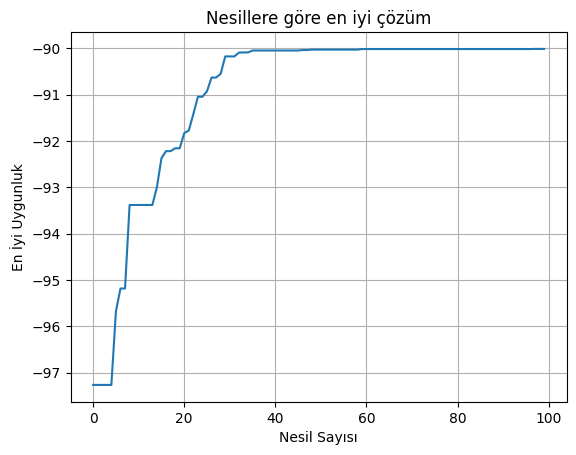

In [43]:
import matplotlib.pyplot as plt
plt.plot(en_iyiler)
plt.xlabel("Nesil Sayısı")
plt.ylabel("En İyi Uygunluk")
plt.title("Nesillere göre en iyi çözüm")
plt.grid(True)
plt.show()

In [44]:
#son nesildeki en iyi çözüm
son_uygunluklar=np.array([uygunluk_hesapla(b) for b in son_pop])
en_iyi_indeks=np.argmax(son_uygunluklar)
en_iyi_birey=son_pop[en_iyi_indeks]

print("\nSon Nesildeki En İyi Çözüm:")
print("X1,x2:",np.round(en_iyi_birey,2))
print("Amaç Fonksiyonu:",round(amac_fonksiyonu(en_iyi_birey),3))
print("Uygunluk:",round(son_uygunluklar[en_iyi_indeks],3))


Son Nesildeki En İyi Çözüm:
X1,x2: [60.01 10.  ]
Amaç Fonksiyonu: -90.012
Uygunluk: -90.012
